In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
import scipy.stats as st
from fitter import Fitter

import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
data=pd.read_csv('demand_ups.csv',index_col=0,header=0)

In [3]:
#We just select SZX-US and HK-US two lanes
#input: 1,3,SZX/US,(default:2019),predict/real

# eg. df=data_select(1,3,2019,'SZX','predict')

lane_dict={'SZX':'SCN-SZX HUB (US)','HK':'HK HUB (US)'}
type_dict={'predict':'predict_d','real':'real_d'}

def data_select(weekday,period,year,lane,datatype='predict'):   
    df=data[(data['Lane']==lane_dict[lane]) & (data['weekday']==weekday) 
            &(data['period']==period) &(data['year']==year)]
    column=['Lane', 'date',type_dict[datatype] ,'weekday', 'month', 'year',
       'quarter', 'period']
    df=df[column]
    df=df[(df[type_dict[datatype]]>=1000)]
    df.reset_index(drop=True,inplace=True)
    df=df.rename(columns={type_dict[datatype]:'demand'})
    return df

In [4]:
def weighted_cluster_model(demand,weight,cost_over,cost_under):
    ######### Parameters Set-up ############
    n=len(demand)
    M=1e20
    ######### Model Set-up ############
    m = Model()
    #capacity
    c = m.addVar(vtype=GRB.CONTINUOUS,name = "capacity")#c23
    y1= m.addVars(n,vtype=GRB.CONTINUOUS,name = "y1")
    y2= m.addVars(n,vtype=GRB.CONTINUOUS,name = "y2")
    z1 = m.addVars(n,2,vtype=GRB.BINARY,name='z1')
    z2 = m.addVars(n,2,vtype=GRB.BINARY,name='z2')
    

    # set objective
    m.setObjective( quicksum((cost_over*y1[i]+cost_under*y2[i])*weight[i] for i in range(n)), GRB.MINIMIZE)#

    # add constraint
    m.addConstrs( y1[i]>=c-demand[i] for i in range(n))
    m.addConstrs( y1[i]>=0 for i in range(n))
    m.addConstrs( y1[i]<=c-demand[i]+M*(1-z1[i,0]) for i in range(n))
    m.addConstrs( y1[i]<=M*(1-z2[i,0]) for i in range(n))
    m.addConstrs( z1[i,0]+z2[i,0]>=1 for i in range(n))
    
    m.addConstrs( y2[i]>=-c+demand[i] for i in range(n))
    m.addConstrs( y2[i]>=0 for i in range(n))
    m.addConstrs( y2[i]<=-c+demand[i]+M*(1-z1[i,1]) for i in range(n))
    m.addConstrs( y2[i]<=M*(1-z2[i,1]) for i in range(n))
    m.addConstrs( z1[i,1]+z2[i,1]>=1 for i in range(n))
    

    # Supressing the optimization output
    m.setParam( 'OutputFlag', False )

    # Solving the model
    m.optimize()
    
    return m,c

In [5]:
def k_plots(weekday,period,year,lane,datatype='predict'):
    df=data_select(weekday,period,year,lane,datatype='predict')
    X=df['demand'].values.reshape(-1,1)
    wcss = []
    for i in range(1, len(X)+1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        # inertia method returns wcss for that model
        wcss.append(kmeans.inertia_)

    sns.lineplot(range(1, len(X)+1), wcss,marker='o',color='red')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    #plt.show()

In [6]:
def total_cost(df,c,t):
    cost = 0
    c13 = c
    cost_over=np.array([7.5,5.7])
    cost_under=np.array([9,7.2])
    for i in range(len(df)):
        d13=df.loc[i,'demand']
        cost=cost + cost_over[t]*max(c13-d13,0)+cost_under[t]*max(d13-c13,0)
    return cost

In [7]:
def cluster(df,k):
    X=df['demand'].values.reshape(-1,1)
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X)  
    y_kmeans = kmeans.fit_predict(X)
    dmd = df['demand'].values
    pred = pd.DataFrame(dmd,columns=['demand'])
    pred['group'] = pd.DataFrame(y_kmeans)
    df_1=pd.DataFrame()
    df_1['group']=range(k)
    df_1['prob']=pred['group'].value_counts(normalize=True,ascending=True)
    df_1['demand_pred']=pred.groupby(['group'])['demand'].mean()
    return(df_1)

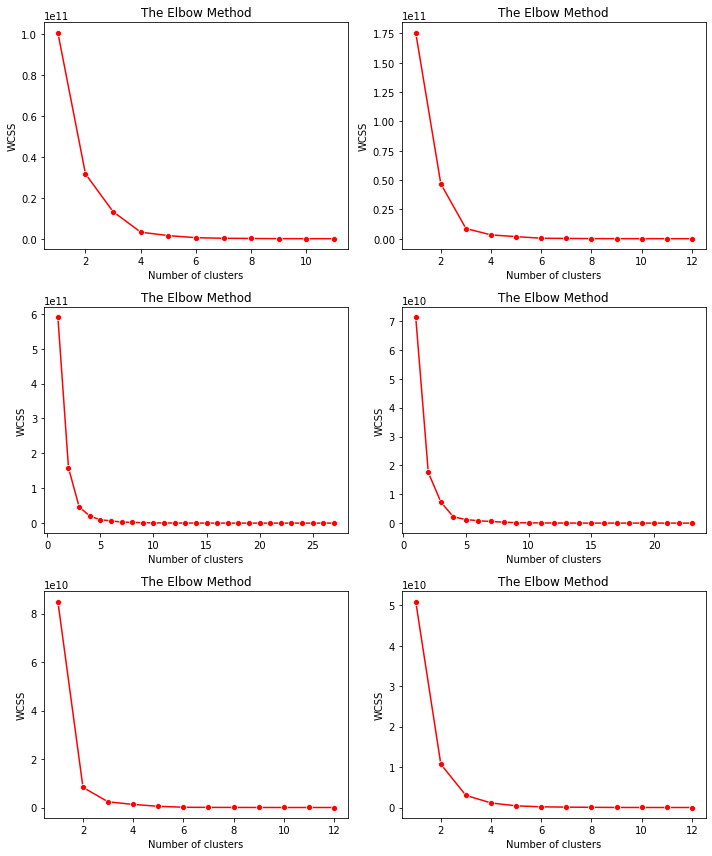

In [8]:
plt.subplots(figsize=(10, 12))
plt.subplot(3,2,1)
k_plots(1,1,2019,'SZX',datatype='predict')
plt.subplot(3,2,2)
k_plots(6,1,2019,'SZX',datatype='predict')
plt.subplot(3,2,3)
k_plots(1,2,2019,'SZX',datatype='predict')
plt.subplot(3,2,4)
k_plots(6,2,2019,'SZX',datatype='predict')
plt.subplot(3,2,5)
k_plots(1,3,2019,'SZX',datatype='predict')
plt.subplot(3,2,6)
k_plots(6,3,2019,'SZX',datatype='predict')
plt.tight_layout()
plt.show()

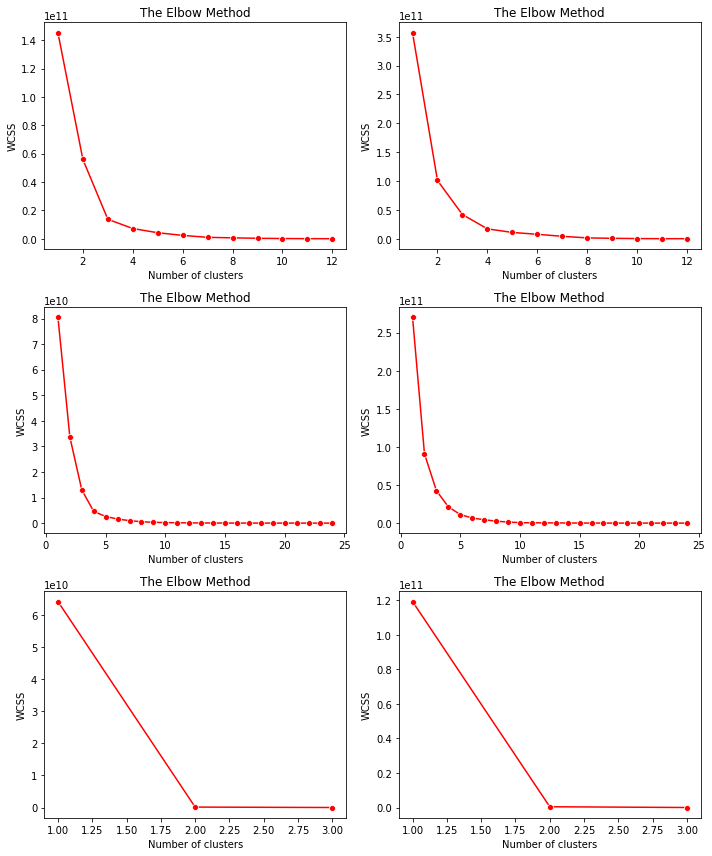

In [9]:
plt.subplots(figsize=(10, 12))
plt.subplot(3,2,1)
k_plots(1,1,2020,'SZX',datatype='predict')
plt.subplot(3,2,2)
k_plots(6,1,2020,'SZX',datatype='predict')
plt.subplot(3,2,3)
k_plots(1,2,2020,'SZX',datatype='predict')
plt.subplot(3,2,4)
k_plots(6,2,2020,'SZX',datatype='predict')
plt.subplot(3,2,5)
k_plots(1,3,2020,'SZX',datatype='predict')
plt.subplot(3,2,6)
k_plots(6,3,2020,'SZX',datatype='predict')
plt.tight_layout()
plt.show()

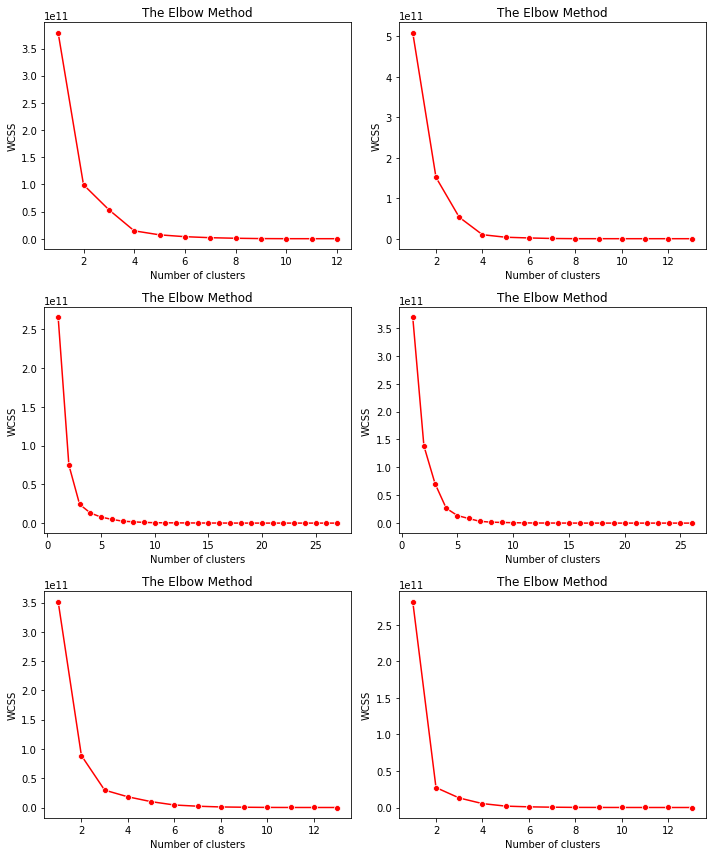

In [10]:
plt.subplots(figsize=(10, 12))
plt.subplot(3,2,1)
k_plots(1,1,2019,'HK',datatype='predict')
plt.subplot(3,2,2)
k_plots(6,1,2019,'HK',datatype='predict')
plt.subplot(3,2,3)
k_plots(1,2,2019,'HK',datatype='predict')
plt.subplot(3,2,4)
k_plots(6,2,2019,'HK',datatype='predict')
plt.subplot(3,2,5)
k_plots(1,3,2019,'HK',datatype='predict')
plt.subplot(3,2,6)
k_plots(6,3,2019,'HK',datatype='predict')
plt.tight_layout()
plt.show()

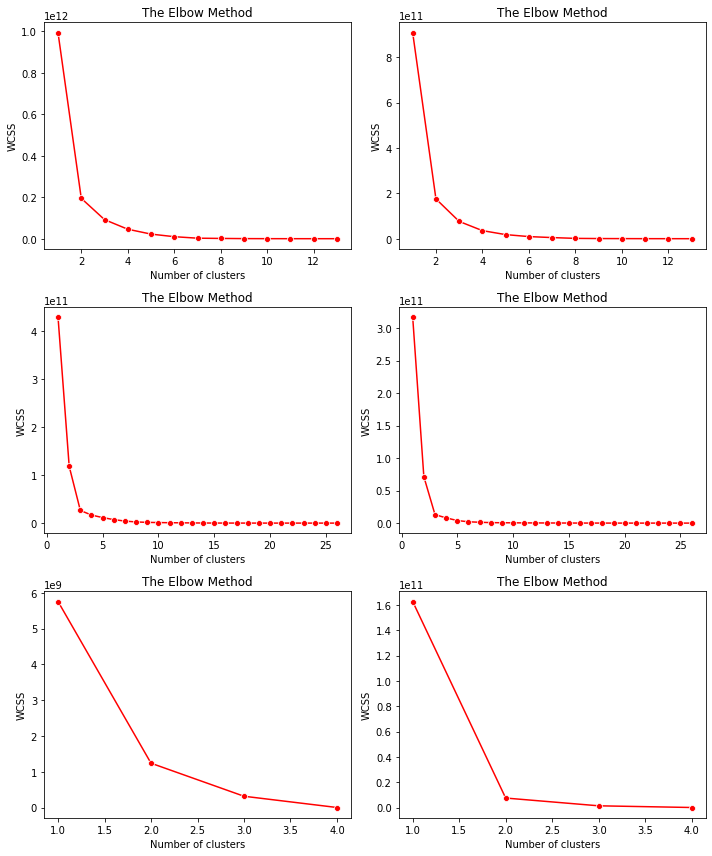

In [11]:
plt.subplots(figsize=(10, 12))
plt.subplot(3,2,1)
k_plots(1,1,2020,'HK',datatype='predict')
plt.subplot(3,2,2)
k_plots(6,1,2020,'HK',datatype='predict')
plt.subplot(3,2,3)
k_plots(1,2,2020,'HK',datatype='predict')
plt.subplot(3,2,4)
k_plots(6,2,2020,'HK',datatype='predict')
plt.subplot(3,2,5)
k_plots(1,3,2020,'HK',datatype='predict')
plt.subplot(3,2,6)
k_plots(6,3,2020,'HK',datatype='predict')
plt.tight_layout()
plt.show()

In [12]:
def outcome_k(weekday,period,year,lane,datatype='predict',k=4):
    df=data_select(weekday,period,year,lane,datatype='predict')
    df_real=data_select(weekday,period,year,lane,datatype='real')
    df1 = cluster(df,k)
    demand=np.array(df1['demand_pred'])
    demand=np.array(df1['demand_pred'])
    n=len(demand)
    weight=np.array(df1['prob'])
    cost_over=np.array([7.5,5.7])
    cost_under=np.array([9,7.2])
    if lane=='SZX':
        t=0
    elif lane=='HK':
        t=1
    m,c=weighted_cluster_model(demand,weight,cost_over[t],cost_under[t])
    capacity=c.x
    cost=total_cost(df,capacity,t)
    cost1=total_cost(df_real,capacity,t)
    print('L =',k)
    print(weekday,period,year,lane,datatype)
    #print('capacity =',capacity)
    #print('predicted total cost =',cost)
    #print('actual total cost =',cost1)
    print(capacity)
    print(cost)
    print(cost1)
    print('-----------------------------------------')

In [13]:
outcome_k(1,1,2019,'SZX','predict',k=4)

Using license file /Users/beijiale/gurobi.lic
Academic license - for non-commercial use only
L = 4
1 1 2019 SZX predict
263742.0
6223317.0
7126104.0
-----------------------------------------


In [14]:
def outcome_n(weekday,period,year,lane,datatype='predict'):
    df=data_select(weekday,period,year,lane,datatype='predict')
    df_real=data_select(weekday,period,year,lane,datatype='real')
    demand=np.array(df['demand'])
    n=len(demand)
    weight=np.array([1/n]*n)
    cost_over=np.array([7.5,5.7])
    cost_under=np.array([9,7.2])
    if lane=='SZX':
        t=0
    elif lane=='HK':
        t=1
    m,c=weighted_cluster_model(demand,weight,cost_over[t],cost_under[t])
    capacity=c.x
    cost=total_cost(df,capacity,t)
    cost1=total_cost(df_real,capacity,t)
    print('L = N')
    print(weekday,period,year,lane,datatype)
    #print('capacity =',capacity)
    #print('predicted total cost =',cost)
    #print('actual total cost =',cost1)
    print(capacity)
    print(cost)
    print(cost1)
    print('-----------------------------------------')

In [15]:
for x4 in ['SZX','HK']:
    for x3 in [2019,2020]:
        for x2 in [1,2,3]:
            for x1 in [1,6]:
                outcome_n(x1,x2,x3,x4,datatype='predict')

L = N
1 1 2019 SZX predict
262101.0
6223317.0
7180257.0
-----------------------------------------
L = N
6 1 2019 SZX predict
412654.0
9373411.5
15254556.0
-----------------------------------------
L = N
1 2 2019 SZX predict
379961.0
17642982.0
22638081.0
-----------------------------------------
L = N
6 2 2019 SZX predict
569900.0
9120358.5
14466372.0
-----------------------------------------
L = N
1 3 2019 SZX predict
531543.0
7392952.5
12439072.5
-----------------------------------------
L = N
6 3 2019 SZX predict
724010.0
5076408.0
13440748.5
-----------------------------------------
L = N
1 1 2020 SZX predict
356971.0
8193627.0
14193546.0
-----------------------------------------
L = N
6 1 2020 SZX predict
471040.0
12434638.5
19482894.0
-----------------------------------------
L = N
1 2 2020 SZX predict
387994.0
8709892.5
19671663.0
-----------------------------------------
L = N
6 2 2020 SZX predict
567158.0
16841257.5
72170571.0
-----------------------------------------
L = N
1 

In [16]:
for x4 in ['SZX','HK']:
    for x3 in [2019,2020]:
        for x2 in [1,2,3]:
            for x1 in [1,6]:
                    if x2==3:
                        k=3
                    elif x2==1 or 2:
                        k=4
                    outcome_k(x1,x2,x3,x4,datatype='predict',k=k)

L = 4
1 1 2019 SZX predict
263742.0
6223317.0
7126104.0
-----------------------------------------
L = 4
6 1 2019 SZX predict
388744.8
9866543.400000002
16438061.400000004
-----------------------------------------
L = 4
1 2 2019 SZX predict
402221.375
18862703.4375
25676622.1875
-----------------------------------------
L = 4
6 2 2019 SZX predict
556992.4285714285
9300787.07142857
14038137.857142858
-----------------------------------------
L = 3
1 3 2019 SZX predict
558224.6666666666
7809088.499999999
15040534.999999998
-----------------------------------------
L = 3
6 3 2019 SZX predict
735710.8571428572
5315514.214285715
12844004.785714285
-----------------------------------------
L = 4
1 1 2020 SZX predict
351927.1666666667
8239021.499999999
14110322.75
-----------------------------------------
L = 4
6 1 2020 SZX predict
472547.4
12445944.0
19396972.2
-----------------------------------------
L = 4
1 2 2020 SZX predict
377376.6666666667
8725818.5
20601936.5
-------------------------

In [17]:
outcome_n(1,1,2019,'SZX','predict')

L = N
1 1 2019 SZX predict
262101.0
6223317.0
7180257.0
-----------------------------------------


In [18]:
outcome_n(6,1,2019,'SZX','predict')

L = N
6 1 2019 SZX predict
412654.0
9373411.5
15254556.0
-----------------------------------------


In [19]:
outcome_n(1,2,2019,'SZX','predict')

L = N
1 2 2019 SZX predict
379961.0
17642982.0
22638081.0
-----------------------------------------


In [20]:
outcome_n(6,2,2019,'SZX','predict')

L = N
6 2 2019 SZX predict
569900.0
9120358.5
14466372.0
-----------------------------------------


In [21]:
outcome_n(1,3,2019,'SZX','predict')

L = N
1 3 2019 SZX predict
531543.0
7392952.5
12439072.5
-----------------------------------------


In [22]:
outcome_n(6,3,2019,'SZX','predict')

L = N
6 3 2019 SZX predict
724010.0
5076408.0
13440748.5
-----------------------------------------


In [23]:
outcome_n(1,1,2020,'SZX','predict')

L = N
1 1 2020 SZX predict
356971.0
8193627.0
14193546.0
-----------------------------------------


In [24]:
outcome_n(6,1,2020,'SZX','predict')

L = N
6 1 2020 SZX predict
471040.0
12434638.5
19482894.0
-----------------------------------------


In [25]:
outcome_n(1,2,2020,'SZX','predict')

L = N
1 2 2020 SZX predict
387994.0
8709892.5
19671663.0
-----------------------------------------


In [26]:
outcome_n(6,2,2020,'SZX','predict')

L = N
6 2 2020 SZX predict
567158.0
16841257.5
72170571.0
-----------------------------------------


In [27]:
outcome_k(1,1,2019,'SZX','predict',4)

L = 4
1 1 2019 SZX predict
263742.0
6223317.0
7126104.0
-----------------------------------------


In [28]:
outcome_k(6,1,2019,'SZX','predict',4)

L = 4
6 1 2019 SZX predict
388744.8
9866543.400000002
16438061.400000004
-----------------------------------------


In [29]:
outcome_k(1,2,2019,'SZX','predict',4)

L = 4
1 2 2019 SZX predict
402221.375
18862703.4375
25676622.1875
-----------------------------------------


In [30]:
outcome_k(6,2,2019,'SZX','predict',4)

L = 4
6 2 2019 SZX predict
556992.4285714285
9300787.07142857
14038137.857142858
-----------------------------------------


In [31]:
outcome_k(1,3,2019,'SZX','predict',3)

L = 3
1 3 2019 SZX predict
558224.6666666666
7809088.499999999
15040534.999999998
-----------------------------------------


In [32]:
outcome_k(6,3,2019,'SZX','predict',3)

L = 3
6 3 2019 SZX predict
735710.8571428572
5315514.214285715
12844004.785714285
-----------------------------------------


In [33]:
outcome_k(1,1,2020,'SZX','predict',4)

L = 4
1 1 2020 SZX predict
351927.1666666667
8239021.499999999
14110322.75
-----------------------------------------


In [34]:
outcome_k(6,1,2020,'SZX','predict',4)

L = 4
6 1 2020 SZX predict
472547.4
12445944.0
19396972.2
-----------------------------------------


In [35]:
outcome_k(1,2,2020,'SZX','predict',4)

L = 4
1 2 2020 SZX predict
377376.6666666667
8725818.5
20601936.5
-----------------------------------------


In [36]:
outcome_k(6,2,2020,'SZX','predict',4)

L = 4
6 2 2020 SZX predict
625260.4444444445
19325022.000000007
62594399.333333336
-----------------------------------------


In [37]:
outcome_n(1,1,2019,'HK','predict')

L = N
1 1 2019 HK predict
546986.0
9712627.5
13602312.900000002
-----------------------------------------


In [38]:
outcome_n(6,1,2019,'HK','predict')

L = N
6 1 2019 HK predict
720949.0
12181983.600000001
16669333.799999999
-----------------------------------------


In [39]:
outcome_n(1,2,2019,'HK','predict')

L = N
1 2 2019 HK predict
524552.0
12448788.300000003
31717004.400000002
-----------------------------------------


In [40]:
outcome_n(6,2,2019,'HK','predict')

L = N
6 2 2019 HK predict
685444.0
15044664.0
17568760.500000004
-----------------------------------------


In [41]:
outcome_n(1,3,2019,'HK','predict')

L = N
1 3 2019 HK predict
852588.0
9590512.5
8153698.5
-----------------------------------------


In [42]:
outcome_n(6,3,2019,'HK','predict')

L = N
6 3 2019 HK predict
893512.0
6275049.9
13304313.000000002
-----------------------------------------


In [43]:
outcome_n(1,1,2020,'HK','predict')

L = N
1 1 2020 HK predict
677789.0
17253661.8
22031716.8
-----------------------------------------


In [44]:
outcome_n(6,1,2020,'HK','predict')

L = N
6 1 2020 HK predict
694993.0
18189148.2
20921647.799999997
-----------------------------------------


In [45]:
outcome_n(1,2,2020,'HK','predict')

L = N
1 2 2020 HK predict
603021.0
14648662.200000001
41066153.39999999
-----------------------------------------


In [46]:
outcome_n(6,2,2020,'HK','predict')

L = N
6 2 2020 HK predict
639147.0
11656589.099999998
34261881.89999999
-----------------------------------------


In [47]:
outcome_k(1,1,2019,'HK','predict',4)

L = 4
1 1 2019 HK predict
509460.75
10061297.175
13881474.150000002
-----------------------------------------


In [48]:
outcome_k(6,1,2019,'HK','predict',4)

L = 4
6 1 2019 HK predict
747027.8333333334
12725824.000000002
17280267.1
-----------------------------------------


In [49]:
outcome_k(1,2,2019,'HK','predict',4)

L = 4
1 2 2019 HK predict
494680.8125
13335358.200000003
35982609.975
-----------------------------------------


In [50]:
outcome_k(6,2,2019,'HK','predict',4)

L = 4
6 2 2019 HK predict
647016.0625
15407974.668750001
16788024.99375
-----------------------------------------


In [51]:
outcome_k(1,3,2019,'HK','predict',3)

L = 3
1 3 2019 HK predict
879992.4285714285
10011850.37142857
8099660.314285714
-----------------------------------------


In [52]:
outcome_k(6,3,2019,'HK','predict',3)

L = 3
6 3 2019 HK predict
889718.3636363636
6287568.9
13023204.545454543
-----------------------------------------


In [53]:
outcome_k(1,1,2020,'HK','predict',4)

L = 4
1 1 2020 HK predict
610012.0
17726399.1
22183114.800000004
-----------------------------------------


In [54]:
outcome_k(6,1,2020,'HK','predict',4)

L = 4
6 1 2020 HK predict
727667.0
18622943.400000002
22078307.400000002
-----------------------------------------


In [55]:
outcome_k(1,2,2020,'HK','predict',4)

L = 4
1 2 2020 HK predict
610133.8888888889
14693473.399999999
40101645.66666668
-----------------------------------------


In [56]:
outcome_k(6,2,2020,'HK','predict',4)

L = 4
6 2 2020 HK predict
624244.8888888889
12125565.766666666
35898133.70000001
-----------------------------------------
